In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from user import User
from average import Average

from tensorflow import keras
from sklearn.model_selection import train_test_split
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

def read_file(file):
    """
    return 2d df after imputing with 0s"""

    # read data
    df = pd.read_csv(file)

    # replace the question marks with NaN and then change data type to float 32
    df.replace(["?"],np.nan, inplace = True)
    df = df.astype(np.float32)

    # imputation
    df.fillna(0,inplace=True) # fill nulls with 0
    return df
def split_dataframe(df, for_user = None, val_size = 0.25, test_size =  0.75, seed = 1):
    """
    split the dataframe into train, validation and test splits based on the same seed
    """
    # split into train, validation and test data using sklearn and return dfs for each
    if for_user!=None:
        df = df[df["User"] == for_user]
    if df.shape[0] == 0:
        # if no data for the user, then return 9 empty dfs as per the api
        # print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return (df for _ in range(9))

    df_train, df_test = train_test_split(df,
                                         test_size = test_size,
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train,
                                         test_size = val_size,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)

    return df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user, \
        df_train, df_train_class, df_train_user

In [3]:
def init_model(init_seed=1):
    """
    initialise and return a model 
    """

    model = keras.Sequential([
        keras.layers.Flatten(),
#         keras.layers.Dense(2048, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
#         keras.layers.Dense(1024, activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(128, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model
def init_users(df, averaging_method):
    """
    initialise users based on dataframe given and assign random averaging method
    to them based on the list passed in.
    returns a dictionary of users(key: user object) and a global user object
    """    
    print("Initialising User instances...")
    users = dict()
    num_users = df["User"].nunique()

    for user_id in range(-1,num_users):

        i = user_id

        if user_id < 0: # for global user with id -1
            user_id = None

        df_val, df_val_class,  df_val_user,\
        df_test, df_test_class, df_test_user,\
        df_train, df_train_class, df_train_user = split_dataframe(df, for_user=user_id)

        user_id = i

        if df_train.shape[0]==0:
            print(f"User {user_id} has no data, no instance created...")
            continue

        model = init_model(init_seed = 1)

        option = np.random.randint(0,len(averaging_methods))
#         print(user_id, averaging_methods[option])
        option = 0
        users[user_id] = User(user_id=user_id,
                          averaging_method = averaging_methods[option],
                          model = model,
                          train_class = df_train_class,
                          train_data = df_train,
                          val_class = df_val_class,
                          val_data = df_val,
                          test_class = df_test_class,
                          test_data = df_test)

    global_user = users.pop(-1)
    global_user.set_averaging_method(averaging_methods[0])
    print(f"{len(users.keys())} User instances and a global user created!")
    return users, global_user

In [4]:
def train_users(users, epochs,
                new_weights = None,
                train_user_verbose_evaluate = 0,
                train_user_verbose_fit = False,
                verbose = True):
    """
    this method is used to train all users on the passed in epochs value
    """
    
    for user in users.values():
        # if user.get_id() < 0:
        #     continue

        if verbose:
            message = f"User {user.get_id()} being trained on the model..."
            print(message)

        user.train(
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            verbose_fit = train_user_verbose_fit,
            verbose_evaluate = train_user_verbose_evaluate
        )

        if verbose:
            message = f"User {user.get_id()} done!"
            print(message)

    return



def train_fed(epochs, rounds, users,
              verbose = True,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_pre = False,
             averaging_post = False,
             averaging_loss = False,
             averaging_accuracy = False):
    """
    this function trains a federation of users using 'strat' stratergy
    central or personalised
    
    central is where all the users send data to a server and the server
    sends back new weights
    
    personalised is where all the users are sent each others data
    and the user tests how their own test data performs on everyone elses models.
    Based on their policy, they then decide what way to average the data
    """

    new_weights = None
    for i in range(rounds):
        if verbose:
            message = f"{'*'*32} {i:^4} {'*'*32}"
            print(message)

        train_users(users, epochs = EPOCHS,
                   new_weights = new_weights,
                   verbose = train_user_verbose,
                   train_user_verbose_evaluate = train_user_verbose_evaluate,
                   train_user_verbose_fit = train_user_verbose_fit)
        if strat == "central":
             new_weights = averaging_method(users, 
                                  pre = averaging_pre,
                                  post = averaging_post, 
                                  accuracy = averaging_accuracy, 
                                  loss = averaging_loss)
#             new_weights = User.static_average_weights(users, method = averaging_method, 
#                                       pre = averaging_pre,
#                                       post = averaging_post, 
#                                       accuracy = averaging_accuracy, 
#                                       loss = averaging_loss)
        elif strat == "personalised":
            for user in users.values():
                user.average_weights(users,
                                    pre = averaging_pre,
                                      post = averaging_post, 
                                      accuracy = averaging_accuracy, 
                                      loss = averaging_loss)
            
        if verbose:
            message = f"{'*'*32} {'DONE':^4} {'*'*32}"
            print(message)
    return


In [5]:
def draw_graphs(user, loss = True, accuracy = True):
    # this is from the book 74,75
    # history = model.fit(...)
    """
    this function draws the history graph for the user from the most
    recent fit performed on it
    """

    history = user.get_history()
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    plt.xlabel('Epochs')

    if loss:
        plt.plot(epochs, acc_values, 'b', label='Training acc')
        plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.clf()
    if accuracy:
        plt.plot(epochs, loss_values, 'b', label='Training loss')
        plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()


def _plot_with_fill(df, x_axis, position, metric, color, std_dev_fill, min_max_fill):
    """
    private function used to plot the average line and provide a fill
    based on the fill strategy passed in
    """

    position_label = f"{position}-fit"
    position_df = df[df["Position"]==f"{position}"]
    avg = position_df["Average"]
    plt.plot(x_axis, avg, color, linewidth = 1, label = f"{position_label} {metric}")

    if std_dev_fill:
        std_dev = position_df["Standard Deviation"]
        plt.fill_between(x_axis, 
                         avg - std_dev, 
                         avg + std_dev, 
                         alpha=0.08, color = color)
    elif min_max_fill:
        mini = position_df["Minimum"]
        maxi = position_df["Maximum"]
        plt.fill_between(x_axis,
                         maxi, 
                         avg, 
                         alpha=0.08, color = color)
        plt.fill_between(x_axis,
                         avg, 
                         mini, 
                             alpha=0.08, color = color)

def _userwise_data(user, 
                     ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    """
    private function used to provide average, std_dev, min, max and final values
    of the defined metric and position which are passed in
    """

    user_data = user.get_data(ignore_first_n = ignore_first_n, 
                                      loss = loss, 
                                      accuracy = accuracy, 
                                      pre= pre,
                                     post = post)
    avg = np.average(user_data)
    std_dev = np.std(user_data)
    mini = np.amin(user_data)
    maxi = np.amax(user_data)
    final = user_data[-1]
    return (user_data,avg, std_dev, mini, maxi,final)        

def userwise_stats_df(users,ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    """
    returns a dataframe of data obtained from userwise_data based on position and metrics with
    cols ["Position", "User", "Average", "Standard Deviation", "Minimum", "Maximum", "Final Value"]
    """

    cols = ["Position", "User", "Average", "Standard Deviation", "Minimum", "Maximum", "Final Value"]
    df = pd.DataFrame(columns = cols)
    df_index = 0    
    for i, user in users.items():
        if post:
            user_data,avg, std_dev, mini, maxi,final = \
              _userwise_data(user, 
                ignore_first_n = ignore_first_n, 
                loss = loss, 
                accuracy = accuracy, 
                post = post)

            df.loc[df_index] = ["Post", i, avg, std_dev, mini, maxi, final]
            df_index +=1
        if pre:
            user_data,avg, std_dev, mini, maxi,final = \
                   _userwise_data(user, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          pre = pre)       
            df.loc[df_index] = ["Pre", i, avg, std_dev, mini, maxi, final]

            df_index +=1 
    return df

def avg_user_stats(users, std_dev_fill = False, min_max_fill = False,
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0, save_as = None, final_values = False):
    
    """
    prints graphs based on per user data and optionally returns the final metric 
    values for them as well. Use save_as to save the graph plotted and can ignore_first_n
    round data in the graphin
    """

    
    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    df = userwise_stats_df(users, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post , pre = pre)
            
    user_ids = list(users.keys())
    # plot here and then fill here
    
    if pre:
        if final_values:
            _print_finals(df, position = "Pre", metric= metric)
            
        _plot_with_fill(df, x_axis = user_ids,
                        position = "Pre",
                        metric = metric,
                        color = "r",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)
    
    if post:
        if final_values:
            _print_finals(df, position = "Post", metric = metric)
        
        _plot_with_fill(df, x_axis = user_ids,
                        position = "Post",
                        metric = metric,
                        color = "b",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)

    
    plt.xlabel("Users")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per User with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    return df


def _print_finals(df, position, metric):
    """
    prints the final averaged value for metric and position defined
    """
    finals =df[df["Position"]==f"{position}"]
    finals = finals[["User", "Final Value"]]
    print(f"Final {metric} for {position}-fit data")
    print(finals)
    print(f"Averaged: {finals['Final Value'].mean()}\n")


def _roundwise_data(users, 
                     ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    """
    returns a tuple of data for based on rounds containing all data, rounds, 
    average, standard deviation, min value and max value per 
    """
    user_data = []
    for i, user in users.items():
        user_data_temp = user.get_data(ignore_first_n = ignore_first_n, 
                                  loss = loss, 
                                  accuracy = accuracy, 
                                  post = post, pre = pre)
        user_data.append(user_data_temp)
    user_data = np.asarray(user_data)
    rounds = len(user_data[0])
    avg = np.average(user_data, axis = 0)
    std_dev = np.std(user_data,  axis = 0)
    mini = np.amin(user_data, axis = 0)
    maxi = np.amax(user_data, axis = 0)
    return (user_data,rounds,avg, std_dev, mini, maxi)        

def roundwise_stats_df(users,ignore_first_n = 0, 
                      loss = False, 
                      accuracy = False, 
                      post = False, pre = False):
    
    """
    returns a data frame of the cols
    ["Position", "Round", "Average", "Standard Deviation", "Minimum", "Maximum"]
    based on data recieved from roundwise_data catered to position and metric passed in
    """
    
    cols = ["Position", "Round", "Average", "Standard Deviation", "Minimum", "Maximum"]
    df = pd.DataFrame(columns = cols)
        
    # collect user metric values into a numpy array
    # of shape (number of users, number of rounds)
    # and calculate roundwise average across all users returning an
    # array for the average of the round across all users
    if post:
        user_data_post,rounds,post_avg, post_std_dev, post_mini, post_maxi = \
                          _roundwise_data(users,
                          ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          post = post)
    if pre:
        user_data_pre,rounds,pre_avg, pre_std_dev, pre_mini, pre_maxi = \
                          _roundwise_data(users,
                          ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                          pre = pre)
        
    # the arrays consisting of averages for all rounds, across n users
    # is then put into a dataframe for roundwise stats required for plotting
    
    rounds = [i+ignore_first_n for i in range(rounds)]
    df_index = 0
    for rnd in rounds:
        rnd -= ignore_first_n
        if pre:
            df.loc[df_index] = ["Pre", rnd+ignore_first_n, 
                                pre_avg[rnd], pre_std_dev[rnd], 
                                pre_mini[rnd], pre_maxi[rnd]]
            df_index +=1
        
        if post:
            df.loc[df_index] = ["Post", rnd+ignore_first_n, 
                                post_avg[rnd], post_std_dev[rnd], 
                                post_mini[rnd], post_maxi[rnd]]
            df_index +=1    
    return (df, rounds)


def avg_round_stats(users, std_dev_fill = False, min_max_fill = False,
                        loss = False, accuracy = False, pre = True, post = True,
                        ignore_first_n = 0, save_as = None, final_values = False):
    
    
    """
    prints graphs based on per round data and optionally returns the final metric 
    values for them as well. Use save_as to save the graph plotted and can ignore_first_n
    round data in the graphin
    """

    if (loss == accuracy) or (std_dev_fill and min_max_fill):
        print("Please select one from accuracy or loss and one or nonefrom std_dev_fill or min_max_fill")
        return None
    # get the data for the prints ready
    metric = "Accuracy"
    if loss:
        metric = "Loss"
    
    fill_type = None
    if std_dev_fill:
        fill_type = "std_dev_fill"
    elif min_max_fill:
        fill_type = "min_max_fill"
    
    
    # data collection into df
    df, rounds = roundwise_stats_df(users, 
                     ignore_first_n = ignore_first_n, 
                          loss = loss, 
                          accuracy = accuracy, 
                        post = post , pre = pre)
    # plot here and then fill here
    if pre:
        if final_values:
            print(f"Final values for Pre-fit {metric}")
            finals = df[df["Position"]=="Pre"].iloc[-1]
            print(finals)

        _plot_with_fill(df, x_axis = rounds,
                        position = "Pre",
                        metric = metric,
                        color = "r",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)
    
    if post:
        if final_values:
            print(f"Final values for Post-fit {metric}")
            finals = df[df["Position"]=="Post"].iloc[-1]
            print(finals,end="\n\n")
        _plot_with_fill(df, x_axis = rounds,
                        position = "Post",
                        metric = metric,
                        color = "b",
                        min_max_fill = min_max_fill, 
                        std_dev_fill = std_dev_fill)

    
    
    plt.xlabel("Rounds")
    plt.ylabel(f"{metric}")
    plt.title(f"Average {metric} per Round with fill type: {fill_type}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()
    return df


In [7]:
#### algorithm:
df = read_file("../dataset/allUsers.lcl.csv")
df_unshuffled = df
# shuffle the records
# df = df.sample(frac = 1)
df = df.take(np.random.permutation(df.shape[0]))
df.reset_index(drop = True, inplace = True)

averaging_methods = ["all","std_dev","weighed_avg"]


DEVICE = '/cpu:0'
ROUNDS = 64
EPOCHS = 16 # 16 is good

# start = time.time()

with tf.device(DEVICE):
    
    users_weighted_avg, global_user = init_users(df, averaging_methods) # return a dictionary of users with data
    train_fed(users = users_weighted_avg, rounds = ROUNDS,
              epochs = EPOCHS,
                            strat = "central",

              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method =  Average.weighted_avg,
             averaging_post = True,
             averaging_accuracy = True)
    
    users_std_dev, global_user = init_users(df, averaging_methods) # return a dictionary of users with data
    train_fed(users = users_std_dev, rounds = ROUNDS,
              epochs = EPOCHS,
                            strat = "central",

              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method =  Average.std_dev,
             averaging_post = True,
             averaging_accuracy = True)
    
    users_all, global_user = init_users(df, averaging_methods) # return a dictionary of users with data
    train_fed(users = users_all, rounds = ROUNDS,
              epochs = EPOCHS,
              strat = "central",
              train_user_verbose = False,
              train_user_verbose_evaluate = False,
              train_user_verbose_fit = False,
              averaging_method = Average.all,
             averaging_post = True,
             averaging_accuracy = True)
    
    
#     users_std_dev, global_user = init_users(df, averaging_methods) # return a dictionary of users with data
#     train_fed(users = users_std_dev, rounds = ROUNDS,
#               epochs = EPOCHS,
#               train_user_verbose = False,
#               train_user_verbose_evaluate = False,
#               train_user_verbose_fit = False,
#               averaging_method = 'all',
#              averaging_post = True,
#              averaging_accuracy = True)
    

#     inter = time.time()

#     users, global_user = init_users(df) # return a dictionary of users with data

#     print("Global user training and validation")
#     global_user.train(epochs = EPOCHS*ROUNDS,
#        verbose_fit = True,
#        verbose_evaluate = True,
#     )
#     draw_graphs(global_user)
    
#     done = time.time()

W1019 18:19:53.090311 15220 deprecation.py:506] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Initialising User instances...
User 3 has no data, no instance created...
13 User instances and a global user created!
********************************  0   ********************************
******************************** DONE ********************************
********************************  1   ********************************
******************************** DONE ********************************
********************************  2   ********************************
******************************** DONE ********************************
********************************  3   ********************************
******************************** DONE ********************************
********************************  4   ********************************
******************************** DONE ********************************
********************************  5   ********************************
******************************** DONE ********************************
*****************************

For all
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.807573
3     1     0.820237
5     2     0.825702
7     4     0.459649
9     5     0.692348
11    6     0.910448
13    7     0.498645
15    8     0.893521
17    9     0.873810
19   10     0.915042
21   11     0.952200
23   12     0.935873
25   13     0.985050
Averaged: 0.8130843822772686

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.972447
2     1     0.988129
4     2     0.969572
6     4     0.698246
8     5     0.985897
10    6     0.997259
12    7     0.579946
14    8     0.983558
16    9     0.982313
18   10     0.981198
20   11     0.991068
22   12     0.990408
24   13     0.999695
Averaged: 0.9322873674906217



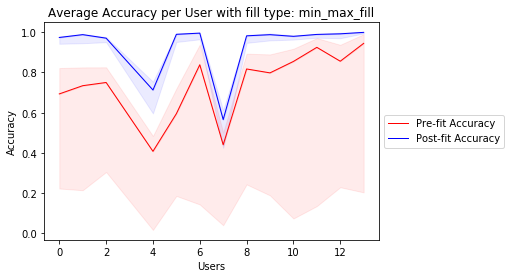

Final values for Pre-fit Accuracy
Position                   Pre
Round                       63
Average               0.813084
Standard Deviation    0.159962
Minimum               0.459649
Maximum                0.98505
Name: 126, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                       63
Average               0.932287
Standard Deviation    0.127411
Minimum               0.579946
Maximum               0.999695
Name: 127, dtype: object



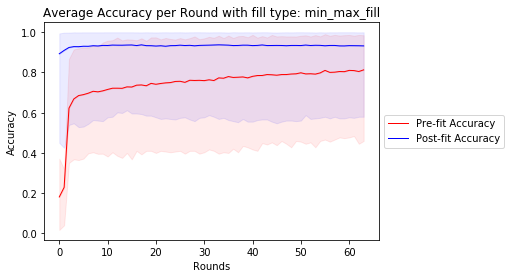

For acc > avg-std
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.822897
3     1     0.847371
5     2     0.859380
7     4     0.428070
9     5     0.689997
11    6     0.912885
13    7     0.474255
15    8     0.849286
17    9     0.928912
19   10     0.957521
21   11     0.944757
23   12     0.950945
25   13     0.980931
Averaged: 0.8190158078303704

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.975394
2     1     0.979650
4     2     0.970753
6     4     0.691228
8     5     0.988248
10    6     0.993603
12    7     0.596206
14    8     0.982971
16    9     0.984354
18   10     0.983148
20   11     0.990076
22   12     0.988490
24   13     0.998932
Averaged: 0.9325425212199872



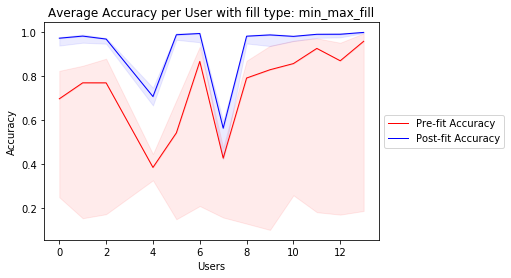

Final values for Pre-fit Accuracy
Position                   Pre
Round                       63
Average               0.819016
Standard Deviation    0.173474
Minimum                0.42807
Maximum               0.980931
Name: 126, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                       63
Average               0.932543
Standard Deviation    0.124758
Minimum               0.596206
Maximum               0.998932
Name: 127, dtype: object



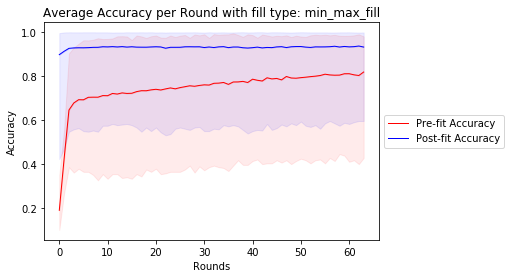

For weight * weighted_avg
Final Accuracy for Pre-fit data
   User  Final Value
1     0     0.801680
3     1     0.838892
5     2     0.795273
7     4     0.442105
9     5     0.686080
11    6     0.926896
13    7     0.441734
15    8     0.824819
17    9     0.888776
19   10     0.860306
21   11     0.954515
23   12     0.873390
25   13     0.991609
Averaged: 0.7943135683353131

Final Accuracy for Post-fit data
   User  Final Value
0     0     0.976426
2     1     0.988977
4     2     0.969867
6     4     0.701754
8     5     0.990598
10    6     0.994822
12    7     0.542005
14    8     0.982776
16    9     0.987755
18   10     0.982173
20   11     0.989745
22   12     0.991505
24   13     0.999390
Averaged: 0.9305993868754461



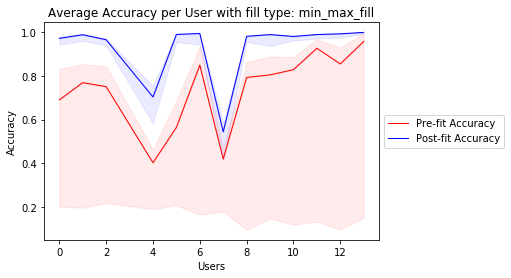

Final values for Pre-fit Accuracy
Position                   Pre
Round                       63
Average               0.794314
Standard Deviation    0.167504
Minimum               0.441734
Maximum               0.991609
Name: 126, dtype: object
Final values for Post-fit Accuracy
Position                  Post
Round                       63
Average               0.930599
Standard Deviation    0.135516
Minimum               0.542005
Maximum                0.99939
Name: 127, dtype: object



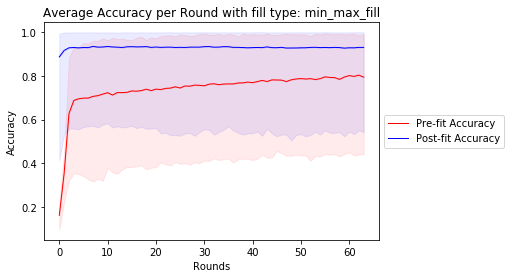

<Figure size 432x288 with 0 Axes>

In [9]:
ignore_first_n = 0
final_values = True
# df_avg_user_stats_loss = avg_user_stats(users, 
#                                         ignore_first_n = ignore_first_n, 
#                                         std_dev_fill = True, 
#                                         loss = True)

# df_avg_round_stats_loss = avg_round_stats(users,
#                                           ignore_first_n = ignore_first_n,
#                                           std_dev_fill = True,
#                                           loss = True)
# std_dev_fill
# min_max_fill

print("For all")

df_avg_user_stats_acc = avg_user_stats(users_all, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)


df_avg_round_stats_acc = avg_round_stats(users_all, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)

print("For acc > avg-std")
df_avg_user_stats_acc = avg_user_stats(users_std_dev, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)

df_avg_round_stats_acc = avg_round_stats(users_std_dev, 
                                         ignore_first_n = ignore_first_n, 
                                     min_max_fill = True, 
                                         accuracy = True,
                                        final_values = final_values)


print("For weight * weighted_avg")

df_avg_user_stats_acc = avg_user_stats(users_weighted_avg, 
                                       ignore_first_n = ignore_first_n, 
                                       min_max_fill = True, 
                                       accuracy = True,
                                      final_values = final_values)


df_avg_round_stats_acc = avg_round_stats(users_weighted_avg, 
                                         ignore_first_n = ignore_first_n, 
                                         min_max_fill = True, 
                                         accuracy = True,
                                         final_values = final_values)


# print(df_avg_round_stats_acc)